# Imports
Import all necessary libraries for data manipulation, model building, training, and evaluation.

In [1]:
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

# Download and Normalize Data
Load the dataset and normalize it using standard scaling techniques to ensure each feature contributes equally to the training process.

In [2]:
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

In [3]:
cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

In [4]:
num_imgs_train = imgs_train.shape[0]
num_imgs_test = imgs_test.shape[0]

print(f"Number of training images: {num_imgs_train}")
print(f"Number of testing images: {num_imgs_test}")

Number of training images: 81
Number of testing images: 10


In [5]:
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)

imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

# Adding Noise to Dataset
Introduce noise into the dataset to create a more robust model that can handle real-world imperfections.

In [6]:
#def add_gaussian_noise(img, mean=0, std=0.1):
#    """ Add Gaussian noise to an image """
#    noise = np.random.normal(mean, std, img.shape)
#    noisy_img = img + noise
#    noisy_img = np.clip(noisy_img, 0, 1)  # Ensure values are within [0, 1]
#    return noisy_img


#def add_ (img, amount=0.02):
#    """ Add salt-and-pepper noise to an image """
#    height, width, channels = img.shape
#    num_pixels = int(amount * height * width)
#    # Generate random coordinates for salt and pepper noise
#    salt_coords = np.random.randint(0, height, num_pixels)
#    pepper_coords = np.random.randint(0, width, num_pixels)
#    # Add salt noise (white pixels)
#    img[salt_coords, pepper_coords] = 255
#    # Add pepper noise (black pixels)
#    img[pepper_coords, salt_coords] = 0
#    return img


def add_speckle_noise(img, scale=0.1):
    # Add speckle noise to an image 
    noise = np.random.randn(*img.shape) * scale
    noisy_img = img + img * noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return noisy_img



#def add_poisson_noise(img):
#    # Add Poisson noise to an image 
#    noisy_img = np.random.poisson(img)
#    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
#    return noisy_img


# Apply noise to the images
noisy_imgs_train = np.array([add_speckle_noise(img) for img in imgs_train])
noisy_imgs_test = np.array([add_speckle_noise(img) for img in imgs_test])


# Visualize the Noisy Images
Visualize the noisy images to understand the effect of noise on the dataset.

there are 17 cells in this image


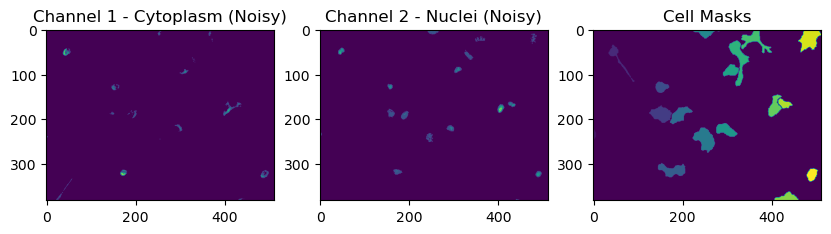

In [7]:
irand = np.random.randint(len(noisy_imgs_train))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(noisy_imgs_train[irand][0])
plt.title('Channel 1 - Cytoplasm (Noisy)')

plt.subplot(1, 3, 2)
plt.imshow(noisy_imgs_train[irand][1])
plt.title('Channel 2 - Nuclei (Noisy)')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('Cell Masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

In [8]:
labels_train = np.zeros((len(masks_train), 2,
                         masks_train.shape[-2],
                         masks_train.shape[-1]),
                        np.longlong)
labels_train[:, 0] = masks_train == 0
labels_train[:, 1] = masks_train > 0

labels_test = np.zeros((len(masks_test), 2,
                        masks_test.shape[-2],
                        masks_test.shape[-1]),
                       np.longlong)
labels_test[:, 0] = masks_test == 0
labels_test[:, 1] = masks_test > 0

# Create Transform Function for Augmentations
Define transformations like rotation, flipping, and zooming to augment the dataset and improve model generalization.

In [9]:

def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale

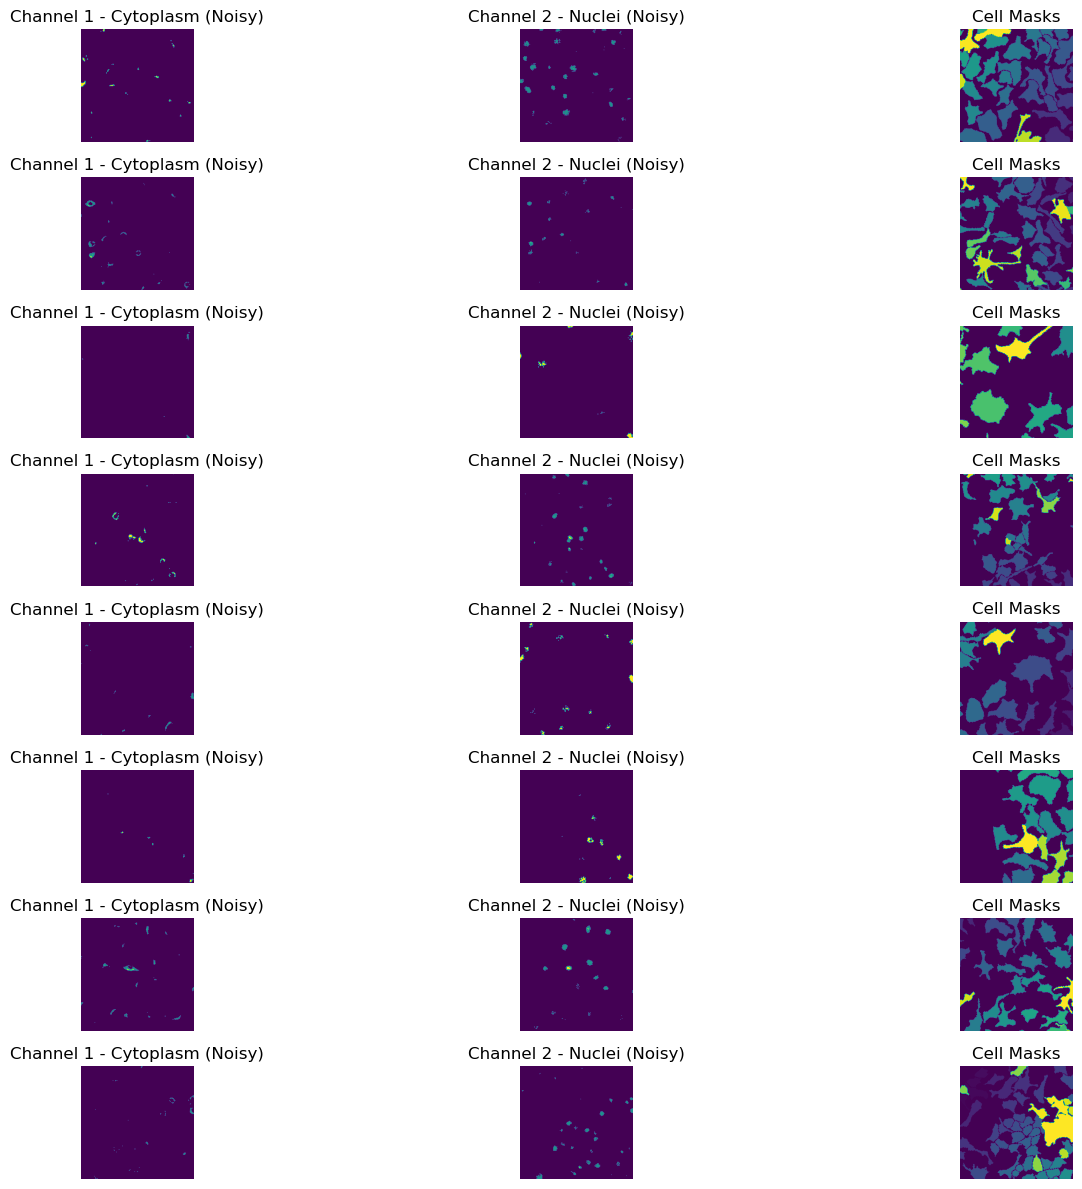

In [10]:
img_batch, lbl_batch, scale = random_rotate_and_resize(noisy_imgs_train[:8],
                                                       masks_train[:8])

plt.figure(figsize=(16, 12))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('Channel 1 - Cytoplasm (Noisy)')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('Channel 2 - Nuclei (Noisy)')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 0])
  plt.title('Cell Masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

# Model Architecture (U-Net)
Define the U-Net architecture, a popular choice for image segmentation tasks due to its encoder-decoder structure.

In [11]:
def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

# Define the Network
Compile the U-Net model with appropriate loss function and optimizer.

In [12]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

# Train the Network
Train the U-Net model with early stopping and learning rate scheduling to prevent overfitting and optimize learning.

In [13]:
from datetime import datetime

# parameters related to training the network
batch_size = 8  # number of images per batch
n_epochs = 50  # number of times to cycle through all the data during training
learning_rate = 0.001  # initial learning rate for Adam
weight_decay = 1e-5  # L2 regularization of weights
n_epochs_per_save = 25  # how often to save the network
val_frac = 0.05  # what fraction of data to use for validation

# where to save the network
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')
 
# split into train and validation datasets
n_val = int(len(imgs_train) * val_frac)
n_train = len(imgs_train) - n_val
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train))
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = labels_train[iperm[:n_train]], labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# gradient descent flavor
optimizer = torch.optim.Adamax(net.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):
    net.train()  # put in train mode (affects batchnorm)
    epoch_loss = 0
    iters = 0
    with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
        # loop through each batch in the training data
        for ibatch in np.arange(0, n_train, batch_size):
            # augment the data
            inds = np.arange(ibatch, min(n_train, ibatch + batch_size))
            train_data = train_data.astype(np.float32)
            train_labels = train_labels.astype(np.float32)
            imgs, lbls, _ = random_rotate_and_resize(train_data[inds],
                                                     train_labels[inds])

            # transfer to torch + GPU
            imgs = torch.from_numpy(imgs).to(device=device)
            lbls = torch.from_numpy(lbls).to(device=device)
            lbls = lbls.long()

            # compute the loss
            y = net(imgs)
            loss = criterion(y, lbls[:, 1])
            epoch_loss += loss.item()
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            # gradient descent
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
            iters += 1
            pbar.update(imgs.shape[0])

        epoch_losses[epoch] = epoch_loss
        pbar.set_postfix(**{'loss (epoch)': epoch_loss})

    # save checkpoint networks every now and then
    if epoch % n_epochs_per_save == 0:
        print(f"\nSaving network state at epoch {epoch + 1}")
        saveepoch = epoch
        savefile = f"unet_epoch{saveepoch + 1}.pth"
        net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch + 1}")
net.save_model(f"unet_epoch{epoch + 1}.pth")

Epoch 1/50: 100%|██████████| 77/77 [00:13<00:00,  5.86img/s, loss (epoch)=3.79] 



Saving network state at epoch 1


Epoch 26/50: 100%|██████████| 77/77 [00:13<00:00,  5.61img/s, loss (epoch)=0.841] 



Saving network state at epoch 26


Epoch 50/50: 100%|██████████| 77/77 [00:13<00:00,  5.53img/s, loss (epoch)=0.817] 


Saving network state at epoch 50


# Test Performance
Evaluate the model performance on the test set using various metrics like confusion matrix, precision, recall, and AUC-ROC.

In [14]:
def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, imgs.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

# Compute results on test images

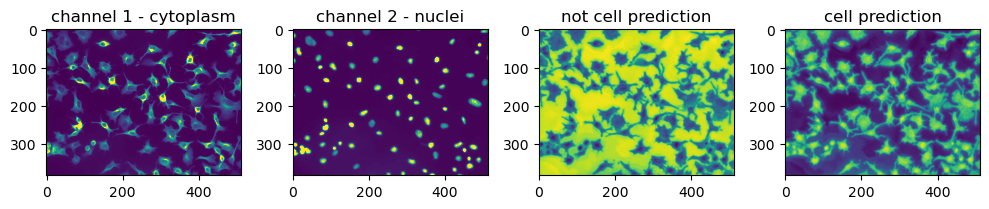

In [15]:
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))

net.eval()
img_padded, slices = pad_image_ND(imgs_test[0], 8)
img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
out = net(img_torch)
labels = out[0][slices].detach().cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(imgs_test[0][0], vmin=0, vmax=1)
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 4, 2)
plt.imshow(imgs_test[0][1], vmin=0, vmax=1)
plt.title('channel 2 - nuclei')

plt.subplot(1, 4, 3)
plt.imshow(labels[0])
plt.title('not cell prediction')

plt.subplot(1, 4, 4)
plt.imshow(labels[1])
plt.title('cell prediction')
plt.tight_layout()
plt.show()

# Setting Threshold for Finding Cells
Define a threshold to accurately identify cells from the segmentation output.# Setting threshold for finding cells

In [16]:
def fill_holes_and_remove_small_masks(masks, min_size=15):
  """ fill holes in masks (2D/3D) and discard masks smaller than min_size (2D)

  fill holes in each mask using scipy.ndimage.morphology.binary_fill_holes

  Parameters
  ----------------
  masks: int, 2D or 3D array
      labelled masks, 0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  min_size: int (optional, default 15)
      minimum number of pixels per mask, can turn off with -1

  Returns
  ---------------
  masks: int, 2D or 3D array
      masks with holes filled and masks smaller than min_size removed,
      0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  """
  slices = find_objects(masks)
  j = 0
  for i,slc in enumerate(slices):
    if slc is not None:
      msk = masks[slc] == (i + 1)
      npix = msk.sum()
      if min_size > 0 and npix < min_size:
        masks[slc][msk] = 0
      else:
        if msk.ndim==3:
          for k in range(msk.shape[0]):
            msk[k] = binary_fill_holes(msk[k])
        else:
          msk = binary_fill_holes(msk)
        masks[slc][msk] = (j + 1)
        j += 1

  return masks


# @markdown `average_precision` function
def average_precision(masks_true, masks_pred, threshold=[0.5, 0.75, 0.9]):
  """ average precision estimation: AP = TP / (TP + FP + FN)

  This function is based heavily on the *fast* stardist matching functions
  (https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py)

  Parameters
  ------------
  masks_true: list of ND-arrays (int)
      where 0=NO masks; 1,2... are mask labels
  masks_pred: list of ND-arrays (int)
      ND-array (int) where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  ap: array [len(masks_true) x len(threshold)]
      average precision at thresholds
  tp: array [len(masks_true) x len(threshold)]
      number of true positives at thresholds
  fp: array [len(masks_true) x len(threshold)]
      number of false positives at thresholds
  fn: array [len(masks_true) x len(threshold)]
      number of false negatives at thresholds
  """
  if not isinstance(threshold, list) and not isinstance(threshold, np.ndarray):
    threshold = [threshold]
  ap  = np.zeros((len(masks_true), len(threshold)), np.float32)
  tp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fn  = np.zeros((len(masks_true), len(threshold)), np.float32)
  n_true = np.array(list(map(np.max, masks_true)))
  n_pred = np.array(list(map(np.max, masks_pred)))
  for n in range(len(masks_true)):
    #_,mt = np.reshape(np.unique(masks_true[n], return_index=True), masks_pred[n].shape)
    if n_pred[n] > 0:
      iou = _intersection_over_union(masks_true[n], masks_pred[n])[1:, 1:]
      for k,th in enumerate(threshold):
        tp[n,k] = _true_positive(iou, th)
    fp[n] = n_pred[n] - tp[n]
    fn[n] = n_true[n] - tp[n]
    ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])

  return ap, tp, fp, fn


@jit(nopython=True)
def _label_overlap(x, y):
  """ fast function to get pixel overlaps between masks in x and y

  Parameters
  ------------
  x: ND-array, int
      where 0=NO masks; 1,2... are mask labels
  y: ND-array, int
      where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  overlap: ND-array, int
      matrix of pixel overlaps of size [x.max()+1, y.max()+1]
  """
  x = x.ravel()
  y = y.ravel()
  overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
  for i in range(len(x)):
    overlap[x[i], y[i]] += 1

  return overlap


def _intersection_over_union(masks_true, masks_pred):
  """ intersection over union of all mask pairs

  Parameters
  ------------
  masks_true: ND-array, int
      ground truth masks, where 0=NO masks; 1,2... are mask labels
  masks_pred: ND-array, int
      predicted masks, where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  iou: ND-array, float
      matrix of IOU pairs of size [x.max()+1, y.max()+1]
  """
  overlap = _label_overlap(masks_true, masks_pred)
  n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
  n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
  iou[np.isnan(iou)] = 0.0

  return iou


def _true_positive(iou, th):
  """ true positive at threshold th

  Parameters
  ------------
  iou: float, ND-array
      array of IOU pairs
  th: float
      threshold on IOU for positive label

  Returns
  ------------
  tp: float
      number of true positives at threshold
  """
  n_min = min(iou.shape[0], iou.shape[1])
  costs = -(iou >= th).astype(float) - iou / (2 * n_min)
  true_ind, pred_ind = linear_sum_assignment(costs)
  match_ok = iou[true_ind, pred_ind] >= th
  tp = match_ok.sum()

  return tp

In [17]:
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)

# Run the Model
Run the model on new data and visualize the results to validate the performance.

Validation Data

0.5581347


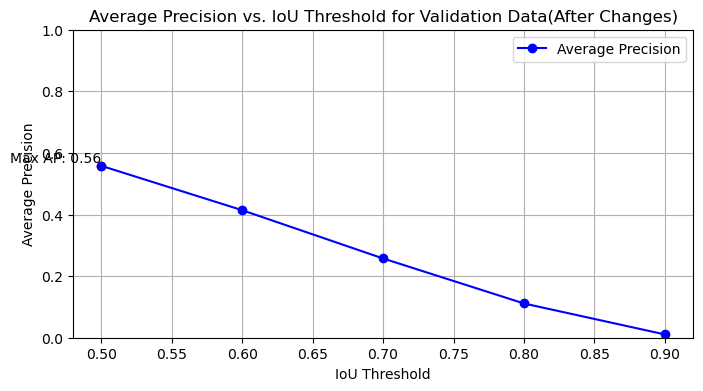

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming net, val_data, val_masks, pad_image_ND, get_masks_unet, and average_precision are defined

net.eval()
val_padded, slices = pad_image_ND(val_data, 8)
val_torch = torch.from_numpy(val_padded).to(device)
out = net(val_torch)

# Compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# Create masks from probabilities
cell_threshold = 2.5
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# Compute average precision
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(val_masks, masks, threshold=iou_threshold)[0]

# Plot results
mean_ap = ap.mean(axis=0)
print(mean_ap[0])

plt.figure(figsize=(8, 4))
plt.plot(iou_threshold, mean_ap, marker='o', linestyle='-', color='b', label='Average Precision')

# Highlight maximum average precision
max_ap_idx = np.argmax(mean_ap)
plt.scatter(iou_threshold[max_ap_idx], mean_ap[max_ap_idx], color='red')
plt.text(iou_threshold[max_ap_idx], mean_ap[max_ap_idx], f'Max AP: {mean_ap[max_ap_idx]:.2f}', 
         horizontalalignment='right', verticalalignment='bottom')

plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision')
plt.title('Average Precision vs. IoU Threshold for Validation Data(After Changes)')
plt.ylim([0, 1])
plt.grid(True)
plt.legend()
plt.savefig('average_precision_validation(speckle_noise)_Adamax.png')
plt.show()

Test Data

0.65513706


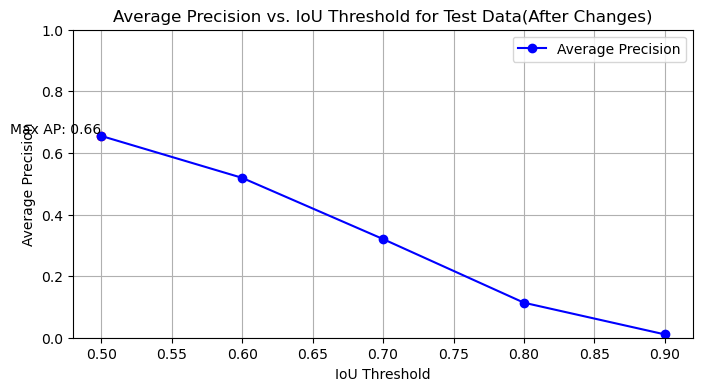

In [19]:
net.eval()
# (depending on GPU capacity you may need to run this in a loop)
test_padded, slices = pad_image_ND(imgs_test, 8)
test_torch = torch.from_numpy(test_padded).to(device)
out = net(test_torch)
# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(masks_test, masks, threshold=iou_threshold)[0]

# Plot results
mean_ap = ap.mean(axis=0)
print(mean_ap[0])

plt.figure(figsize=(8, 4))
plt.plot(iou_threshold, mean_ap, marker='o', linestyle='-', color='b', label='Average Precision')

# Highlight maximum average precision
max_ap_idx = np.argmax(mean_ap)
plt.scatter(iou_threshold[max_ap_idx], mean_ap[max_ap_idx], color='red')
plt.text(iou_threshold[max_ap_idx], mean_ap[max_ap_idx], f'Max AP: {mean_ap[max_ap_idx]:.2f}', 
         horizontalalignment='right', verticalalignment='bottom')

plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision')
plt.title('Average Precision vs. IoU Threshold for Test Data(After Changes)')
plt.ylim([0, 1])
plt.grid(True)
plt.legend()
plt.savefig('average_precision_test(speckle_noise)_Adamax.png')
plt.show()

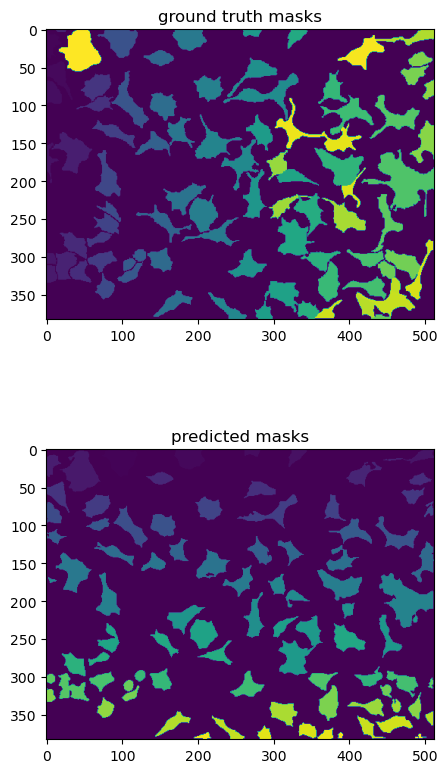

In [20]:
plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.imshow(masks_test[0])
plt.title('ground truth masks')
plt.subplot(2, 1, 2)
plt.imshow(masks[0])
plt.title('predicted masks')
plt.savefig('Comparing True Mask predicted Mask.png')
plt.show()